# Benchmark against other methods


In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pickle
import json
import seaborn as sns
import matplotlib.transforms as mtransforms
from bread import vis
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bread.algo import tracking
from bread.data import *
from sklearn.metrics import confusion_matrix
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
from glob import glob
import sys
import os.path
sys.path.append('../../src/libraries')  # import YeaZ

## Load testing data


In [30]:
seg = SegmentationFile.from_h5(
    '../../data/external_edited/external_segmentation.h5').get_segmentation("FOV0")
microscopy = Microscopy.from_tiff(
    '../../data/external/external_microscopy.tif')
# first make fatures with scale 1 to find the correct scale
feat = Features(seg, nn_threshold=12, scale_length=1, scale_time=1)

# on average, first frame cells have an area of 2078.0 in the train set
mean_cell_area = 2078.0
area_list = []
cells_first_frame = seg.cell_ids(0)
for cell in cells_first_frame:
    area_list.append(feat.cell_area(0, cell))
scale = mean_cell_area / np.mean(area_list)
print(scale)
print(np.mean(area_list))
print(np.mean(area_list) * scale)
# replace features with correct scale
feat = Features(seg, nn_threshold=12, scale_length=scale, scale_time=1)

2.88410825815406
720.5
2078.0


In [31]:
print(feat.cell_area(0, 1))
print(feat.cell_area(0, 2))
print(feat.cell_area(0, 3))

6496.42082735166
7057.891257372449
4425.2187966083


In [32]:
max_dt = 4
interframes = [(idt, idt+dt) for idt, dt in itertools.product(
    range(len(seg)), range(1, max_dt+1)) if idt+dt < len(seg)]
print(f'{len(interframes)} interframe samples')

470 interframe samples


In [33]:
results = {'gcn': {}, 'yeaz': {}, 'tracx': {}}

In [34]:
recompute = True  # notebook flag to force recomputing the accuracies

In [35]:
# directory for results
basedir = Path('../../data/generated/tracking/compare/colony_external')

## Our method (GCN)


In [36]:
modelpath = Path('../../data/generated/tracking/models/2023-06-14 14:30:22/')

### Load model from pickle


In [37]:
with open(modelpath / 'pickle.pkl', 'rb') as file:
    net: tracking.AssignmentClassifier = pickle.load(file)

net.trim_for_prediction()
net

<class 'bread.algo.tracking._classifier.AssignmentClassifier'>[initialized](
  module_=GNNTracker(
    (node_encoder): MLP(12, 120, 120, 120, 120)
    (edge_encoder): MLP(10, 120, 120, 120, 120)
    (layers): ModuleList(
      (0-4): 5 x DeepGCNLayer(block=res+)
    )
    (out): MLP(120, 60, 30, 1)
  ),
)

In [38]:
ga = tracking.build_assgraph(tracking.build_cellgraph(
    feat, 50), tracking.build_cellgraph(feat, 55), include_target_feature=True)
gat, *_ = tracking.to_data(ga)
yhat = net.predict_assignment(gat)
print(yhat)
yhat = yhat.flatten()
y = gat.y.squeeze().cpu().numpy()
confusion_matrix(y, yhat.flat)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

array([[619,   2],
       [  2,  21]])

### Load model from params


In [39]:
from bread.algo.tracking import GraphLoader, GNNTracker, InMemoryAssignmentDataset
from skorch.classifier import NeuralNetClassifier
import torch

with open(modelpath / 'hyperparams.json') as file:
    hparams = json.load(file)

# first initialize the model
new_net = NeuralNetClassifier(
    GNNTracker,
    module__num_node_attr=hparams['num_node_attr'],
    module__num_edge_attr=hparams['num_edge_attr'],
    module__dropout_rate=hparams['dropout_rate'],
    module__encoder_hidden_channels=hparams['encoder_hidden_channels'],
    module__encoder_num_layers=hparams['encoder_num_layers'],
    module__conv_hidden_channels=hparams['conv_hidden_channels'],
    module__conv_num_layers=hparams['conv_num_layers'],
    module__num_classes=1,
    iterator_train=GraphLoader,
    iterator_valid=GraphLoader,
    criterion=torch.nn.BCEWithLogitsLoss,
).initialize()
new_net.load_params(modelpath / 'params.pt')

dataset = InMemoryAssignmentDataset([
    tracking.to_data(tracking.build_assgraph(tracking.build_cellgraph(
        feat, 50), tracking.build_cellgraph(feat, 55), include_target_feature=True))[0]
])
# unactivated outputs
print(new_net.forward(dataset[0:1]).reshape(
    (len(dataset[0].cell_ids1), len(dataset[0].cell_ids2))))
# activated outputs
# WARNING : this is just applying a rounding operation, this is not the linear assignment !!
print(new_net.predict(dataset[0:1]).reshape(
    (len(dataset[0].cell_ids1), len(dataset[0].cell_ids2))))

tensor([[ 1.3385, -1.8850, -1.9286, -2.1036, -2.1934, -2.1053, -1.7795, -2.1066,
         -2.2155, -2.0317, -2.0995, -2.0705, -2.0829, -2.1320, -1.9492, -2.2090,
         -2.0793, -2.0582, -2.2617, -2.0465, -2.2137, -2.8754, -1.9950, -2.1266,
         -1.9797, -2.5843, -2.1926, -2.3164],
        [-1.3399,  2.0153, -1.8541, -2.0282, -2.0718, -2.0517, -1.9386, -1.9723,
         -1.9850, -2.0790, -2.0857, -2.1047, -2.0611, -1.9361, -2.0075, -2.0982,
         -2.0097, -1.9842, -1.8867, -1.9045, -2.0098, -2.8801, -2.2161, -1.7544,
         -1.6999, -2.4093, -1.8909, -2.5882],
        [-2.3288, -2.3093,  3.5112, -2.2589, -2.3119, -2.2064, -2.2479, -2.1149,
         -2.3574, -2.2519, -2.2130, -2.2668, -2.1419, -2.3845, -2.3213, -2.2265,
         -2.3216, -1.7388, -2.6102, -2.3500, -2.3429, -3.1458, -1.8786, -2.7445,
         -2.1505, -3.1129, -2.1612, -2.7165],
        [-2.2114, -2.1345, -2.0683,  1.1274, -2.1116, -2.2667, -2.0858, -2.1795,
         -1.9208, -2.1127, -2.2311, -2.1105, -2.2393

### compute


In [40]:
if recompute:
    results['gcn'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for idt1, idt2 in tqdm(interframes):
        ga = tracking.build_assgraph(tracking.build_cellgraph(
            feat, idt1), tracking.build_cellgraph(feat, idt2), include_target_feature=True)
        gat, *_ = tracking.to_data(ga)

        yhat = net.predict_assignment(gat).flatten()
        y = gat.y.squeeze().cpu().numpy()

        results['gcn']['confusion'].append(confusion_matrix(y, yhat))
        results['gcn']['t1'].append(idt1)
        results['gcn']['t2'].append(idt2)

100%|██████████| 470/470 [1:38:40<00:00, 12.60s/it] 


## YeaZ


In [41]:
import YeaZ.unet.hungarian as YeaZ_hung

In [42]:
import scipy.spatial.distance


def match_cellids_from_segs(segframe1: np.ndarray, segframe2: np.ndarray, eps=1e-6):
    # Matches cellids between two identical segmentations, which use different numberings
    seg1 = Segmentation(segframe1[None, ...], 'FOV0')
    seg2 = Segmentation(segframe2[None, ...], 'FOV0')
    cms1 = seg1.cms(0)
    cms2 = seg2.cms(0)

    # compare centers of masses
    dists = scipy.spatial.distance.cdist(cms1, cms2)
    matches = dists < eps
    idx1, idx2 = matches.nonzero()
    assert not len(idx2) < len(cms1), 'not all cells were matched'
    assert not len(idx2) > len(cms1), 'too many cells were matched'

    return idx2

In [43]:
if recompute:
    results['yeaz'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for idt1, idt2 in tqdm(interframes):
        seg_hat = YeaZ_hung.correspondence(seg[idt1], seg[idt2])
        idmap2 = match_cellids_from_segs(seg[idt2], seg_hat)

        y = tracking.assignment_from_segmentation(seg, idt1, idt2)
        yhat = tracking.assignment_from_segmentation(seg, idt1, idt2)[
            :, idmap2]

        results['yeaz']['confusion'].append(
            confusion_matrix(y.flatten(), yhat.flatten()))
        results['yeaz']['t1'].append(idt1)
        results['yeaz']['t2'].append(idt2)

100%|██████████| 470/470 [07:36<00:00,  1.03it/s]


## TracX


In [44]:
# since tracx works with matlab, we need to export the data to a convenient format
# then run it via matlab
# then analyze the results

import tifffile

fileid2frameid = defaultdict(dict)
dowrite = True

for dt in range(1, max_dt+1):
    maskdir = str(basedir / 'TracX/framediff{:02d}/mask').format(dt)
    microdir = str(basedir / 'TracX/framediff{:02d}/microscopy').format(dt)

    os.makedirs(maskdir, exist_ok=True)
    os.makedirs(microdir, exist_ok=True)

    fileid = 0
    for startframe in tqdm(range(0, dt), desc=f'framediff', leave=False, position=0):
        for frameid in tqdm(range(startframe, len(seg), dt), desc=f'framediff={dt}', position=1):
            fileid2frameid[dt][fileid] = frameid
            if dowrite:
                tifffile.imsave(
                    f'{maskdir}/mask_{fileid:03d}.tif', seg[frameid].astype('int32'))
                tifffile.imsave(
                    f'{microdir}/phc_{fileid:03d}.tif', microscopy.get_frame(
                        'FOV0', frameid).astype('int32')
                )
            fileid += 1

if dowrite:
    with open(basedir / 'TracX/fileid2frameid.json', 'w') as f:
        json.dump(fileid2frameid, f)

framediff:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_90273/2407484340.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(
/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_90273/2407484340.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(
framediff=4: 100%|██████████| 30/30 [00:00<00:00, 193.18it/s]


In [45]:
# run the tracking in matlab and generate results in basedir / TracX_results/ ...

In [46]:
dfs_tracx_res = []

for framediff in range(1, max_dt+1):
    filepath = basedir / \
        f'TracX_results/TrackingResults_framediff{framediff:02d}.txt'
    df = pd.read_csv(filepath, sep='\t', usecols=[
                     'cell_frame', 'cell_index', 'track_index'])
    df['frameid'] = df.cell_frame.map(lambda f: fileid2frameid[1][f-1])
    df.drop(columns='cell_frame', inplace=True)
    df['framediff'] = framediff
    dfs_tracx_res.append(df)

df_tracx_res = pd.concat(dfs_tracx_res)

In [47]:
if recompute:
    results['tracx'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for _, group_framediff in tqdm(df_tracx_res.groupby('framediff'), desc='framediff', leave=False):
        framediff = group_framediff.framediff.iloc[0]

        for (_, group1), (_, group2) in tqdm(itertools.product(group_framediff.groupby('frameid'), repeat=2), desc=f'framediff={framediff}', leave=False):
            idt1, idt2 = group1.frameid.iloc[0], group2.frameid.iloc[0]

            # loop only over idt -> idt+framediff
            if idt2 - idt1 != framediff or idt2 < idt1:
                continue

            ass_tracx = np.empty(
                (len(group1.cell_index), len(group2.cell_index)))
            ass = np.empty((len(group1.cell_index), len(group2.cell_index)))

            try:
                for idx1, idx2 in itertools.product(range(len(group1.cell_index)), range(len(group2.cell_index))):
                    ass_tracx[idx1, idx2] = group1.track_index.iloc[idx1] == group2.track_index.iloc[idx2]
                    # the input to TracX are segmentations where the cellids are already tracked correctly
                    # so the tracking is just where the cell indices match
                    ass[idx1, idx2] = group1.cell_index.iloc[idx1] == group2.cell_index.iloc[idx2]
            except:
                # TODO: fix this
                ass[idx1, idx2] = 1

            results['tracx']['confusion'].append(
                confusion_matrix(ass.flatten(), ass_tracx.flatten()))
            results['tracx']['t1'].append(idt1)
            results['tracx']['t2'].append(idt2)

## Compare results


### Create results dataframe


In [48]:
import datetime

resultsfile = basedir / \
    f'results_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

if recompute:
    dfs = []

    for method in results:
        res = pd.DataFrame(results[method])
        res['method'] = method
        dfs.append(res)

    res = pd.concat(dfs, ignore_index=True)

    num_cells = [len(seg.cell_ids(idt)) for idt in range(len(seg))]

    res['tp'] = res['confusion'].map(lambda c: c[1, 1])
    res['fp'] = res['confusion'].map(lambda c: c[0, 1])
    res['tn'] = res['confusion'].map(lambda c: c[0, 0])
    res['fn'] = res['confusion'].map(lambda c: c[1, 0])
    res['acc'] = (res['tp'] + res['tn']) / \
        (res['tp'] + res['fp'] + res['tn'] + res['fn'])
    res['f1'] = 2*res['tp'] / (2*res['tp'] + res['fp'] + res['fn'])
    res['num_cells1'] = res['t1'].map(lambda t: num_cells[int(t)])
    res['num_cells2'] = res['t2'].map(lambda t: num_cells[int(t)])
    res['timediff'] = 5 * (res['t2'] - res['t1'])
    res.drop(columns='confusion', inplace=True)
    res.to_csv(resultsfile)

else:
    res = pd.read_csv(resultsfile, index_col=0)

In [49]:
res.sort_values(by='t1', ascending=True).sort_values(by='t2', ascending=True)

t1   t2 method   tp   fp      tn   fn       acc        f1  num_cells1  \
0       0    1    gcn    3    0       6    0  1.000000  1.000000           3   
470     0    1   yeaz    3    0       6    0  1.000000  1.000000           3   
940     0    1  tracx    3    0       6    0  1.000000  1.000000           3   
4       1    2    gcn    3    0       6    0  1.000000  1.000000           3   
941     1    2  tracx    3    0       6    0  1.000000  1.000000           3   
...   ...  ...    ...  ...  ...     ...  ...       ...       ...         ...   
1409  115  119  tracx  147   16   55094   20  0.999349  0.890909         267   
933   115  119   yeaz  189   78   88032   78  0.998235  0.707865         267   
463   115  119    gcn  163  104   88006  104  0.997646  0.610487         267   
1176  117  119  tracx  266    1   88109    1  0.999977  0.996255         294   
469   118  119    gcn  300   10  102290   10  0.999805  0.967742         310   

      num_cells2  timediff  
0              3         5  
470            3         5  
940            3         5  
4              3         5  
941            3         5  
...          ...       ...  
1409         331        20  
933          331        20  
463          331        20  
1176         331        10  
469          331         5  

[1410 rows x 12 columns]

In [51]:
yeaz_res = res[res.method == 'yeaz']
gcn_res = res[res.method == 'gcn']
tracx_res = res[res.method == 'tracx']

In [52]:
tracx_res

t1   t2 method   tp  fp     tn  fn       acc        f1  num_cells1  \
940     0    1  tracx    3   0      6   0  1.000000  1.000000           3   
941     1    2  tracx    3   0      6   0  1.000000  1.000000           3   
942     2    3  tracx    3   0      6   0  1.000000  1.000000           3   
943     3    4  tracx    3   0      6   0  1.000000  1.000000           3   
944     4    5  tracx    3   0      6   0  1.000000  1.000000           3   
...   ...  ...    ...  ...  ..    ...  ..       ...       ...         ...   
1405  111  115  tracx   83   1  14109   2  0.999789  0.982249         229   
1406  112  116  tracx  103   3  21290   4  0.999673  0.967136         237   
1407  113  117  tracx  113   6  28038  10  0.999432  0.933884         251   
1408  114  118  tracx  132   9  38295  12  0.999454  0.926316         262   
1409  115  119  tracx  147  16  55094  20  0.999349  0.890909         267   

      num_cells2  timediff  
940            3         5  
941            3         5  
942            3         5  
943            3         5  
944            3         5  
...          ...       ...  
1405         267        20  
1406         279        20  
1407         294        20  
1408         310        20  
1409         331        20  

[470 rows x 12 columns]

In [53]:
res_merge = pd.merge(gcn_res, tracx_res, on=[
                     't1', 't2', 'timediff'], suffixes=('_gcn', '_tracx'))
res_merge

t1   t2 method_gcn  tp_gcn  fp_gcn  tn_gcn  fn_gcn   acc_gcn    f1_gcn  \
0      0    1        gcn       3       0       6       0  1.000000  1.000000   
1      0    2        gcn       3       0       6       0  1.000000  1.000000   
2      0    3        gcn       3       0       6       0  1.000000  1.000000   
3      0    4        gcn       3       0       6       0  1.000000  1.000000   
4      1    2        gcn       3       0       6       0  1.000000  1.000000   
..   ...  ...        ...     ...     ...     ...     ...       ...       ...   
465  116  118        gcn     268      11   86200      11  0.999746  0.960573   
466  116  119        gcn     228      51   92019      51  0.998895  0.817204   
467  117  118        gcn     292       2   90844       2  0.999956  0.993197   
468  117  119        gcn     277      17   97003      17  0.999651  0.942177   
469  118  119        gcn     300      10  102290      10  0.999805  0.967742   

     num_cells1_gcn  ...  timediff  method_tracx tp_tracx  fp_tracx  tn_tracx  \
0                 3  ...         5         tracx        3         0         6   
1                 3  ...        10         tracx        3         0         6   
2                 3  ...        15         tracx        3         0        15   
3                 3  ...        20         tracx        3         0        15   
4                 3  ...         5         tracx        3         0         6   
..              ...  ...       ...           ...      ...       ...       ...   
465             279  ...        10         tracx      250         1     73542   
466             279  ...        15         tracx      209         5     71935   
467             294  ...         5         tracx      292         1     90845   
468             294  ...        10         tracx      266         1     88109   
469             310  ...         5         tracx      304         5    102295   

     fn_tracx  acc_tracx  f1_tracx  num_cells1_tracx  num_cells2_tracx  
0           0   1.000000  1.000000                 3                 3  
1           0   1.000000  1.000000                 3                 3  
2           0   1.000000  1.000000                 3                 3  
3           0   1.000000  1.000000                 3                 3  
4           0   1.000000  1.000000                 3                 3  
..        ...        ...       ...               ...               ...  
465         1   0.999973  0.996016               279               310  
466         9   0.999806  0.967593               279               331  
467         2   0.999967  0.994889               294               310  
468         1   0.999977  0.996255               294               331  
469         6   0.999893  0.982229               310               331  

[470 rows x 21 columns]

In [54]:
res_merge = res_merge[['t1', 't2', 'tp_tracx', 'tp_gcn',
                       'fp_tracx', 'fp_gcn', 'tn_tracx', 'tn_gcn', 'fn_tracx', 'fn_gcn', 'num_cells1_gcn', 'num_cells1_tracx', 'num_cells2_gcn', 'num_cells2_tracx', 'timediff']]

In [55]:
res_merge.loc[(res_merge.fp_gcn != res_merge.fp_tracx)
              & (res_merge.timediff == 5)]

t1   t2  tp_tracx  tp_gcn  fp_tracx  fp_gcn  tn_tracx  tn_gcn  fn_tracx  \
200   50   51        23      22         0       1       552     551         0   
396   99  100       143     144         1       0     21167   21168         1   
424  106  107       190     191         1       0     38008   38009         1   
448  112  113       236     235         0       2     59250   59248         1   
460  115  116       267     266         0       1     74226   74225         0   
467  117  118       292     292         1       2     90845   90844         2   
469  118  119       304     300         5      10    102295  102290         6   

     fn_gcn  num_cells1_gcn  num_cells1_tracx  num_cells2_gcn  \
200       1              23                23              25   
396       0             144               144             148   
424       0             191               191             200   
448       2             237               237             251   
460       1             267               267             279   
467       2             294               294             310   
469      10             310               310             331   

     num_cells2_tracx  timediff  
200                25         5  
396               148         5  
424               200         5  
448               251         5  
460               279         5  
467               310         5  
469               331         5

In [56]:
yeaz_res.loc[(yeaz_res.timediff == 5) & (yeaz_res.fp+yeaz_res.fn > 0)]

t1  t2 method  tp  fp    tn  fn       acc        f1  num_cells1  \
738  67  68   yeaz  42   1  1977   1  0.999010  0.976744          43   
782  78  79   yeaz  66   1  4488   1  0.999561  0.985075          67   

     num_cells2  timediff  
738          47         5  
782          68         5

### Sanity checks


In [57]:
res.groupby(['timediff', 'method'])[['f1']].mean()

f1
timediff method          
5        gcn     0.999009
         tracx   0.999185
         yeaz    0.999679
10       gcn     0.990513
         tracx   0.981514
         yeaz    0.995670
15       gcn     0.964349
         tracx   0.941476
         yeaz    0.980848
20       gcn     0.911091
         tracx   0.869112
         yeaz    0.950794

In [58]:
res_sum = res.groupby(['timediff', 'method'])[
    ['f1', 'tp', 'fp', 'fn', 'tn', 'num_cells1', 'num_cells2']].sum()
res_sum['precision'] = res_sum['tp'] / (res_sum['tp'] + res_sum['fp'])
res_sum['recall'] = res_sum['tp'] / (res_sum['tp'] + res_sum['fn'])
res_sum['f1'] = 2*res_sum['tp'] / \
    (2*res_sum['tp'] + res_sum['fp'] + res_sum['fn'])
res_sum[['f1', 'precision', 'recall']]

f1  precision    recall
timediff method                               
5        gcn     0.997857   0.997857  0.997857
         tracx   0.998423   0.998864  0.997983
         yeaz    0.999748   0.999748  0.999748
10       gcn     0.979664   0.979664  0.979664
         tracx   0.996455   0.996879  0.996031
         yeaz    0.992784   0.992784  0.992784
15       gcn     0.925764   0.925764  0.925764
         tracx   0.981981   0.986147  0.977850
         yeaz    0.962063   0.962063  0.962063
20       gcn     0.815009   0.815009  0.815009
         tracx   0.946904   0.958954  0.935152
         yeaz    0.901404   0.901404  0.901404

In [59]:
res_sum.to_csv(
    f'/Users/farzanehwork/Documents/results/tracking/colony_external_compare_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

In [60]:
res_sum

f1    tp    fp    fn       tn  num_cells1  num_cells2  \
timediff method                                                                
5        gcn     0.997857  7915    17    17  1275662        7932        8260   
         tracx   0.998423  7916     9    16  1275670        7932        8260   
         yeaz    0.999748  7930     2     2  1275677        7932        8260   
10       gcn     0.979664  7467   155   155  1224546        7622        8257   
         tracx   0.996455  7027    22    28  1134103        7622        8257   
         yeaz    0.992784  7567    55    55  1224646        7622        8257   
15       gcn     0.925764  6784   544   544  1176446        7328        8254   
         tracx   0.981981  5695    80   129   938419        7328        8254   
         yeaz    0.962063  7050   278   278  1176712        7328        8254   
20       gcn     0.815009  5745  1304  1304  1131060        7049        8251   
         tracx   0.946904  4182   179   290   724141        7049        8251   
         yeaz    0.901404  6354   695   695  1131669        7049        8251   

                 precision    recall  
timediff method                       
5        gcn      0.997857  0.997857  
         tracx    0.998864  0.997983  
         yeaz     0.999748  0.999748  
10       gcn      0.979664  0.979664  
         tracx    0.996879  0.996031  
         yeaz     0.992784  0.992784  
15       gcn      0.925764  0.925764  
         tracx    0.986147  0.977850  
         yeaz     0.962063  0.962063  
20       gcn      0.815009  0.815009  
         tracx    0.958954  0.935152  
         yeaz     0.901404  0.901404

In [61]:
res.groupby(['timediff', 'method'])[['acc']].sum()

acc
timediff method            
5        gcn     118.995199
         tracx   118.996271
         yeaz    118.998571
10       gcn     117.960157
         tracx   117.981678
         yeaz    117.972490
15       gcn     116.822930
         tracx   116.925953
         yeaz    116.882532
20       gcn     115.633993
         tracx   115.744783
         yeaz    115.724489

In [62]:
res.groupby(['timediff', 'method'])[['acc']].count()

acc
timediff method     
5        gcn     119
         tracx   119
         yeaz    119
10       gcn     118
         tracx   118
         yeaz    118
15       gcn     117
         tracx   117
         yeaz    117
20       gcn     116
         tracx   116
         yeaz    116

In [63]:
res.groupby(['method', 'timediff'])[['acc']].mean()

acc
method timediff          
gcn    5         0.999960
       10        0.999662
       15        0.998487
       20        0.996845
tracx  5         0.999969
       10        0.999845
       15        0.999367
       20        0.997800
yeaz   5         0.999988
       10        0.999767
       15        0.998996
       20        0.997625

### Evaluate CI & plot


In [64]:
from scipy.stats import bootstrap

In [65]:
def frac_perfect(col):
    return (col == 1.0).sum() / len(col)

In [66]:
def frac_perfect_ci(col):
    # we need to test this otherwise scipy complains about degeneracy
    if all(col == 1):
        return (1.0, 1.0)
    bs = bootstrap((col,), statistic=frac_perfect,
                   vectorized=False, random_state=0)
    return bs.confidence_interval.low, bs.confidence_interval.high


def mean_ci(col):
    if all(col == 1):
        return (1.0, 1.0)
    bs = bootstrap((col,), statistic=np.mean, vectorized=False, random_state=0)
    return bs.confidence_interval.low, bs.confidence_interval.high

In [67]:
res_agg = (res
           .groupby(['timediff', 'method'])
           [['acc']]
           .agg([frac_perfect, frac_perfect_ci, np.mean, mean_ci, np.median])
           .reset_index()
           )
res_agg[[('acc', 'frac_perfect_ci_lower'), ('acc', 'frac_perfect_ci_higher')]] = pd.DataFrame(
    res_agg[('acc', 'frac_perfect_ci')].tolist(), index=res_agg.index)
res_agg[[('acc', 'mean_ci_lower'), ('acc', 'mean_ci_higher')]] = pd.DataFrame(
    res_agg[('acc', 'mean_ci')].tolist(), index=res_agg.index)
res_agg.drop(columns=[('acc', 'mean_ci'),
             ('acc', 'frac_perfect_ci')], inplace=True)
res_agg

timediff method          acc                                            \
                   frac_perfect      mean    median frac_perfect_ci_lower   
0         5    gcn     0.949580  0.999960  1.000000              0.899160   
1         5  tracx     0.915966  0.999969  1.000000              0.857143   
2         5   yeaz     0.983193  0.999988  1.000000              0.941176   
3        10    gcn     0.728814  0.999662  1.000000              0.644068   
4        10  tracx     0.838983  0.999845  1.000000              0.762712   
5        10   yeaz     0.813559  0.999767  1.000000              0.737288   
6        15    gcn     0.487179  0.998487  0.999814              0.401709   
7        15  tracx     0.692308  0.999367  1.000000              0.598291   
8        15   yeaz     0.615385  0.998996  1.000000              0.529915   
9        20    gcn     0.362069  0.996845  0.998198              0.284483   
10       20  tracx     0.422414  0.997800  0.999715              0.336207   
11       20   yeaz     0.431034  0.997625  0.999442              0.344828   

                                                        
   frac_perfect_ci_higher mean_ci_lower mean_ci_higher  
0                0.983193      0.999822       0.999995  
1                0.957983      0.999883       0.999995  
2                1.000000      0.999957       1.000000  
3                0.805085      0.999283       0.999825  
4                0.898305      0.999555       0.999957  
5                0.872881      0.999379       0.999913  
6                0.581197      0.997389       0.999051  
7                0.769231      0.998916       0.999645  
8                0.700855      0.998302       0.999422  
9                0.456897      0.995548       0.997666  
10               0.517241      0.996734       0.998419  
11               0.525862      0.996280       0.998423

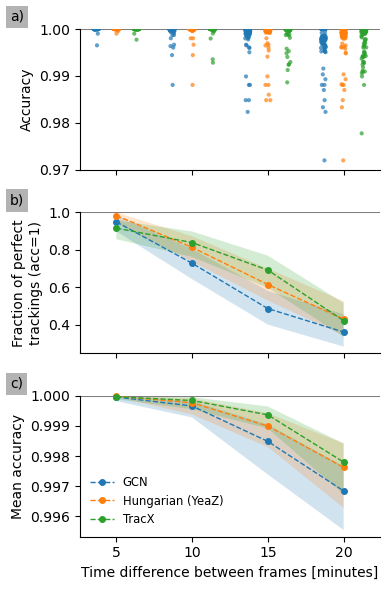

In [68]:
fig, axs = plt.subplot_mosaic([['a)'], ['b)'], ['c)']], figsize=(
    4, 6), sharex=True, tight_layout=True)

axs['b)'].axhline(1.0, color='tab:gray')
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'gcn'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect[res_agg.method == 'gcn'],
               'o--', markersize=4, linewidth=1,
               label='GCN', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'yeaz'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect[res_agg.method == 'yeaz'],
               'o--', markersize=4, linewidth=1,
               label='Hungarian (YeaZ)', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'tracx'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect[res_agg.method == 'tracx'],
               'o--', markersize=4, linewidth=1,
               label='TracX', clip_on=False)
# axs['b)'].set_xlabel('Time difference between frames [minutes]')
axs['b)'].set_ylabel('Fraction of perfect\ntrackings (acc=1)')
axs['b)'].spines.top.set_visible(False)
axs['b)'].spines.right.set_visible(False)
# axs['b)'].legend(fontsize='small', frameon=False)
axs['b)'].set_ylim((None, 1.0))

axs['c)'].axhline(1.0, color='tab:gray')
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean_ci_lower'][res_agg.method == 'gcn'], res_agg.acc['mean_ci_higher'][res_agg.method == 'gcn'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean'][res_agg.method == 'gcn'],
               'o--', markersize=4, linewidth=1,
               label='GCN', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean_ci_lower'][res_agg.method == 'yeaz'], res_agg.acc['mean_ci_higher'][res_agg.method == 'yeaz'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean'][res_agg.method == 'yeaz'],
               'o--', markersize=4, linewidth=1,
               label='Hungarian (YeaZ)', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean_ci_lower'][res_agg.method == 'tracx'], res_agg.acc['mean_ci_higher'][res_agg.method == 'tracx'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean'][res_agg.method == 'tracx'],
               'o--', markersize=4, linewidth=1,
               label='TracX', clip_on=False)
axs['c)'].set_ylabel('Mean accuracy')
axs['c)'].spines.top.set_visible(False)
axs['c)'].spines.right.set_visible(False)
axs['c)'].legend(fontsize='small', frameon=False)
axs['c)'].set_ylim((None, 1.0))
axs['c)'].set_xlabel('Time difference between frames [minutes]')

sns.stripplot(
    data=res, x='timediff', y='acc', hue='method',
    dodge=True, s=3, alpha=0.7, ax=axs['a)'], legend=False, native_scale=True,
    # clip_on=False,
)
axs['a)'].axhline(1.0, color='tab:gray')
# some outliers from YeaZ and trackx are not shown !!
axs['a)'].set_ylim((0.97, 1))
axs['a)'].set_ylabel('Accuracy')
axs['a)'].set_xlabel('Time difference between frames [minutes]')
axs['a)'].set_xticks(res_agg.timediff.unique())
axs['a)'].spines.top.set_visible(False)
axs['a)'].spines.right.set_visible(False)

for label, ax in axs.items():
    # label physical distance in and down
    trans = mtransforms.ScaledTranslation(-0.7, 0.05, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='bottom',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# fig.savefig('../report_gnn/figures/timediff_accuracy.pdf')
plt.show()

### Evaluate p-value from bootstrapped samples


In [69]:
from typing import Callable
from scipy.stats import ttest_ind


def bootstrap_sample(
        x: np.ndarray,
        n: int = 10_000,
        agg: Callable[[np.ndarray], float] = np.mean
) -> np.ndarray:
    """Compute confidence interval of a given data aggregate

    Parameters
    ----------
    x : np.ndarray
            data
    alpha : float, optional
            size of the confidence interval, by default 0.95
    n : int, optional
            number of resamples, by default 1_000
    agg : Callable[[np.ndarray], float], optional
            aggregation function, by default np.mean

    Returns
    -------
    aggs: np.ndarray of length ``n``
    """

    aggs = np.zeros(n)

    for i in range(n):
        # resample data uniformly
        sample = x[np.random.randint(0, len(x), len(x))]
        aggs[i] = agg(sample)

    return np.sort(aggs)

-- timediff = 5 --
t-test gcn <-> tracx : Ttest_indResult(statistic=12.062933268059213, pvalue=2.378306856754307e-28)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-21.979263921262056, pvalue=2.201172223759027e-68)
-- timediff = 10 --
t-test gcn <-> tracx : Ttest_indResult(statistic=-28.263242198707438, pvalue=3.354790120174627e-93)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-19.48334198269282, pvalue=3.739955764275476e-58)
-- timediff = 15 --
t-test gcn <-> tracx : Ttest_indResult(statistic=-45.50459491592661, pvalue=6.656922814935565e-151)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-29.059746408000883, pvalue=3.25667969560001e-96)
-- timediff = 20 --
t-test gcn <-> tracx : Ttest_indResult(statistic=-12.84426148710072, pvalue=2.5681151389434625e-31)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-15.616423172904556, pvalue=2.709234104479161e-42)


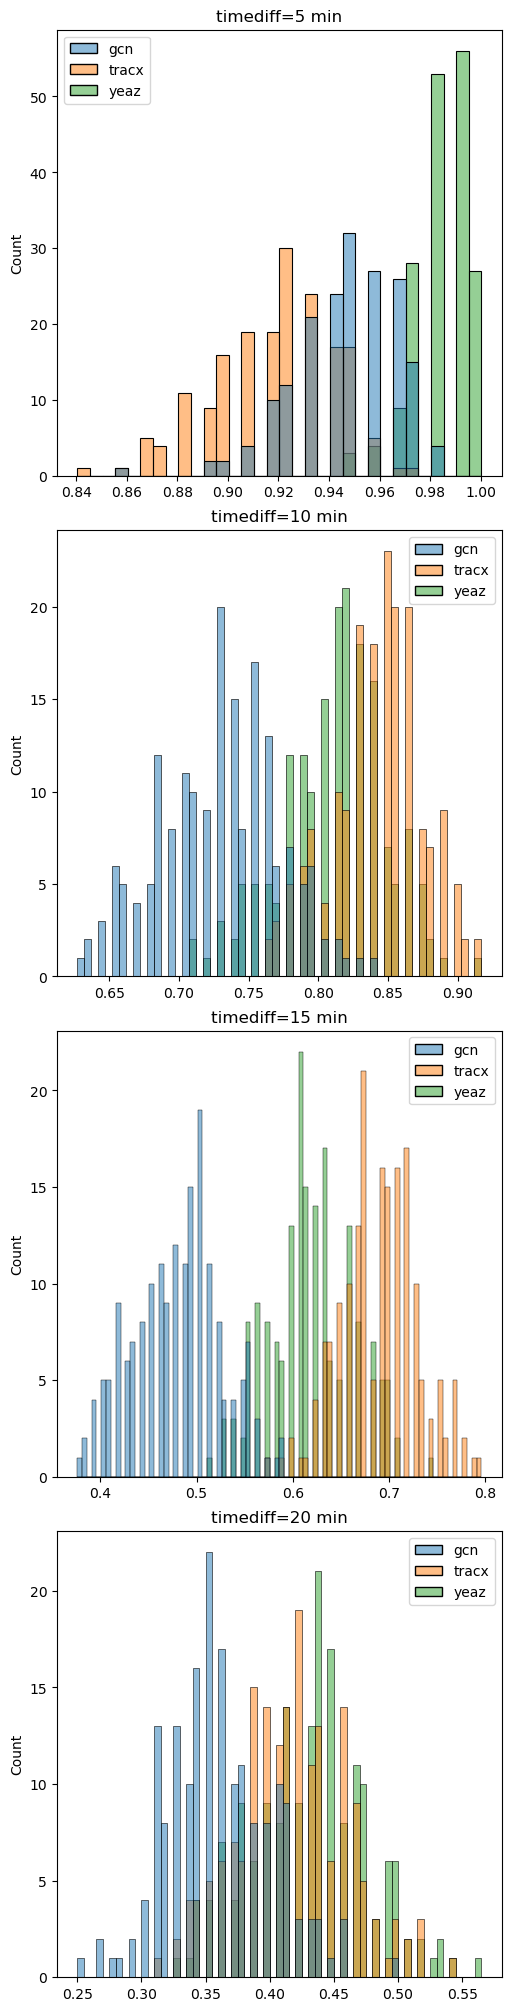

In [70]:
fig, axs = plt.subplots(nrows=res.timediff.nunique(),
                        figsize=(5, 20), constrained_layout=True)

for ax, timediff in zip(axs, res.timediff.unique()):
    print(f'-- timediff = {timediff} --')

    # we resample ~180 times because that's the number of datapoints we have
    sample_gcn = bootstrap_sample(res.query(
        'timediff == @timediff and method == "gcn"').acc.to_numpy(), n=180, agg=frac_perfect)
    sample_tracx = bootstrap_sample(res.query(
        'timediff == @timediff and method == "tracx"').acc.to_numpy(), n=180, agg=frac_perfect)
    sample_yeaz = bootstrap_sample(res.query(
        'timediff == @timediff and method == "yeaz"').acc.to_numpy(), n=180, agg=frac_perfect)

    sns.histplot(dict(gcn=sample_gcn, tracx=sample_tracx,
                 yeaz=sample_yeaz), binwidth=0.005, ax=ax)
    ax.set_title(f'timediff={timediff} min')

    print(f't-test gcn <-> tracx : {ttest_ind(sample_gcn, sample_tracx)}')
    print(f't-test gcn <-> yeaz : {ttest_ind(sample_gcn, sample_yeaz)}')

## What induces mistakes ?


In [71]:
# resultsfile = basedir / \
#     f'results_2023-07-04_20-43-11.csv'
# saved_res = pd.read_csv(resultsfile, index_col=0)

Expected 11->11, got 11->13


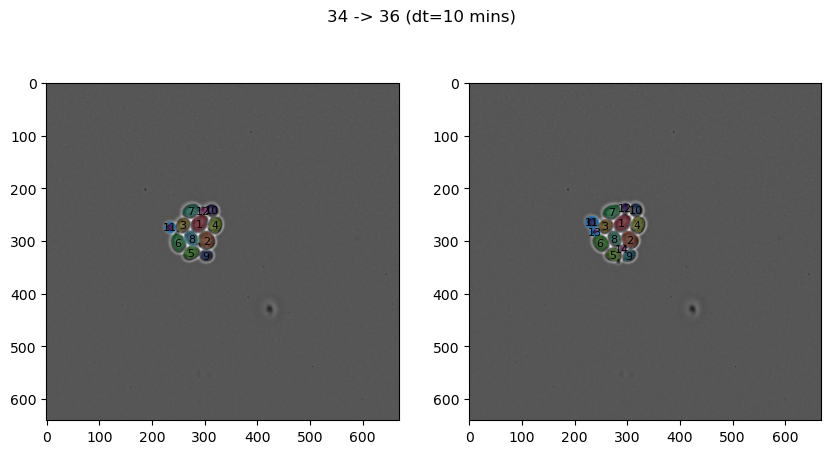

Expected 17->17, got 17->20


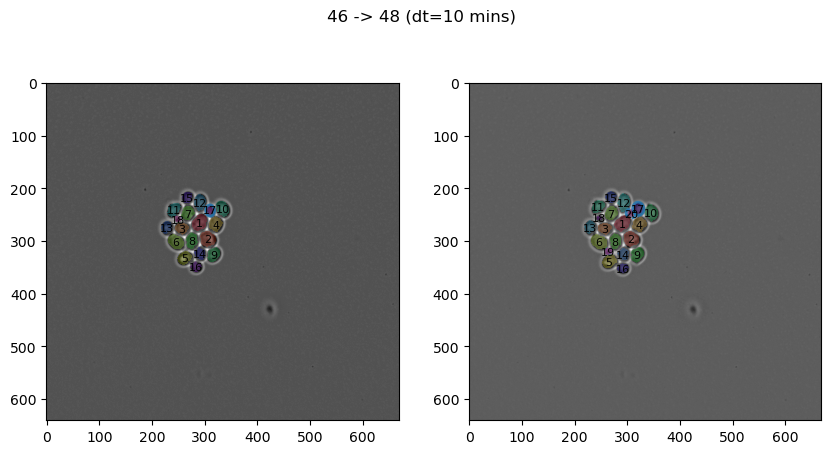

Expected 9->9, got 9->24


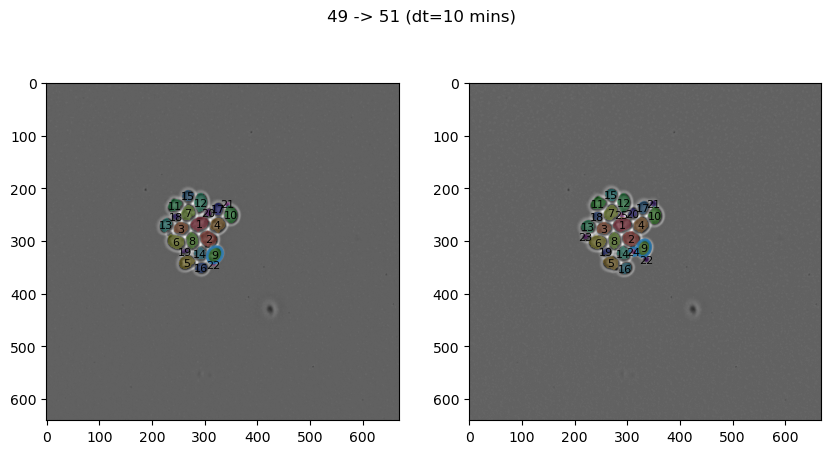

Expected 22->22, got 22->24


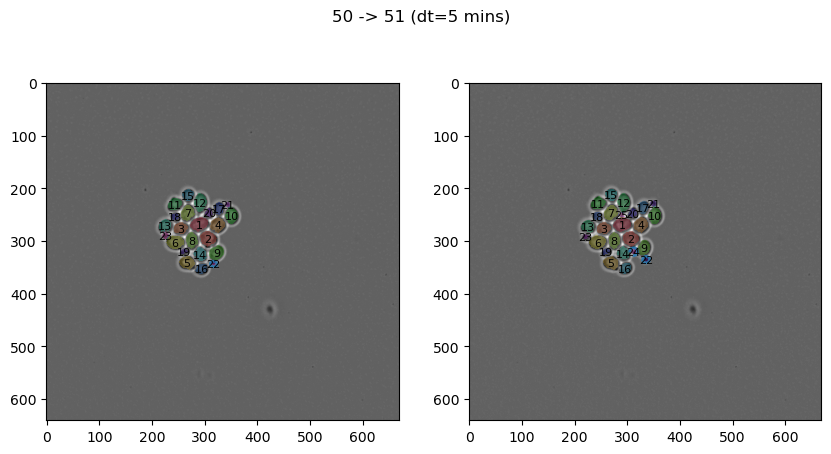

Expected 22->22, got 22->24


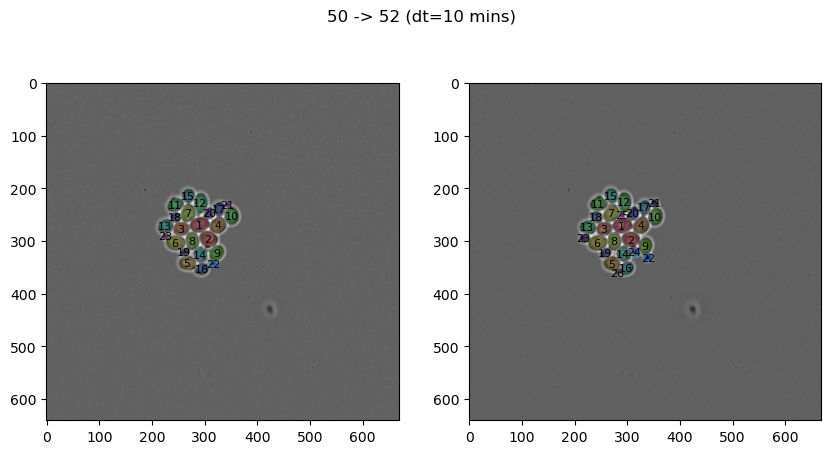

Expected 21->21, got 21->40


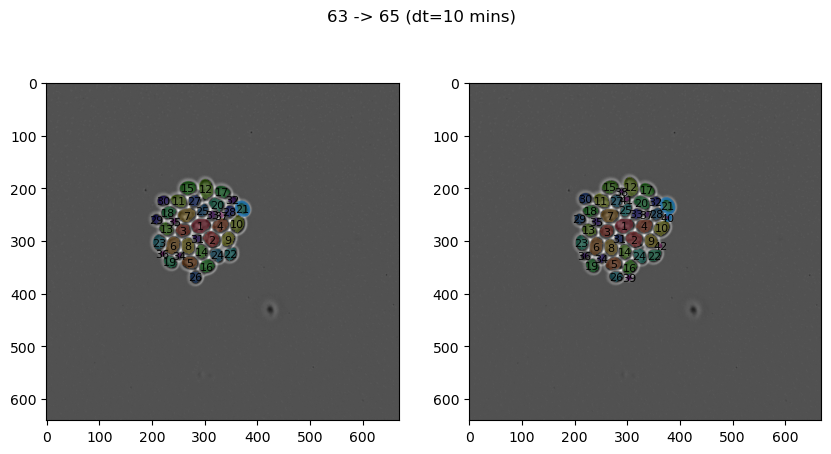

Expected 26->26, got 26->46
Expected 37->37, got 37->44


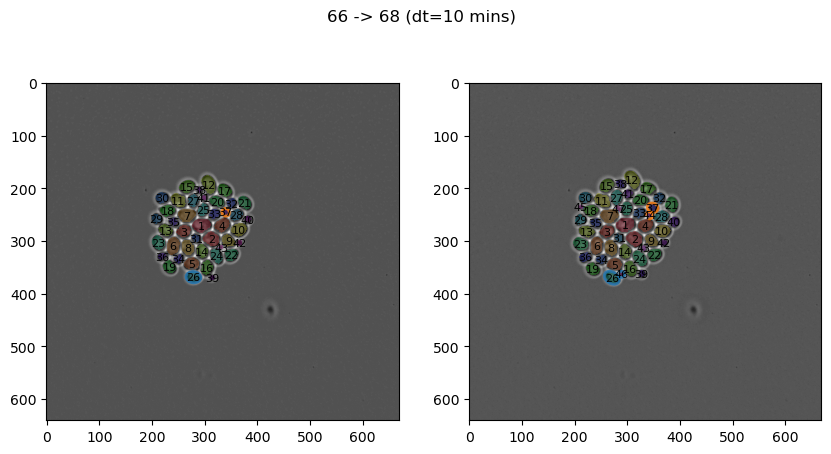

Expected 26->26, got 26->46
Expected 27->27, got 27->47
Expected 32->32, got 32->37
Expected 37->37, got 37->44


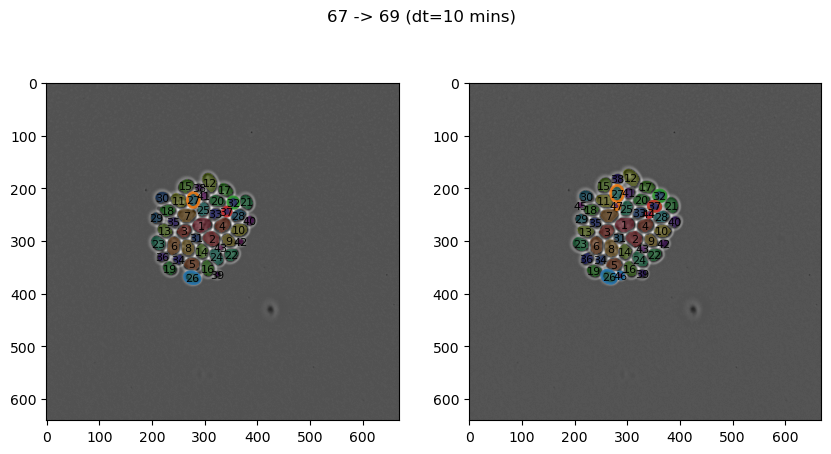

Expected 37->37, got 37->44


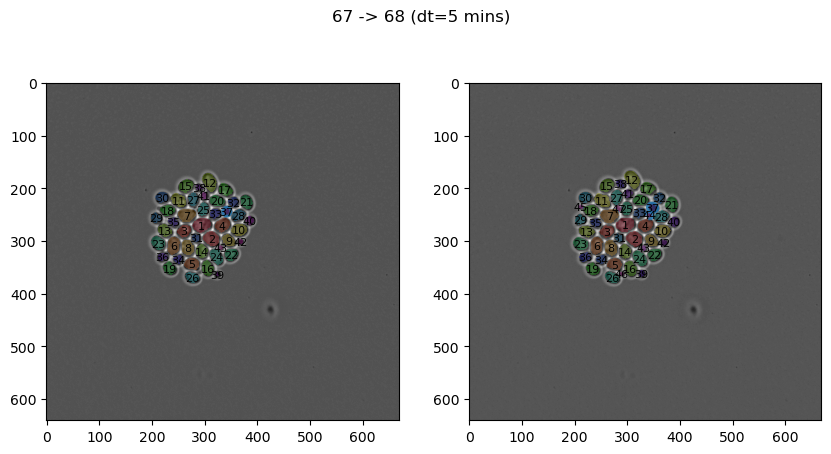

Expected 57->57, got 57->68


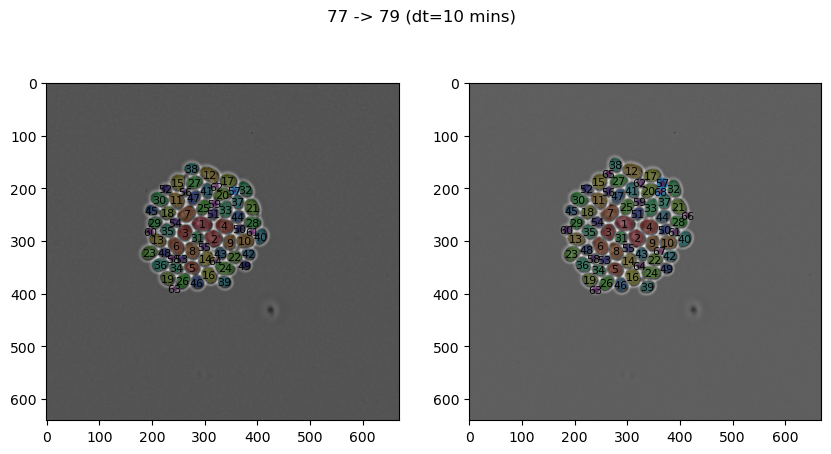

Expected 4->4, got 4->69
Expected 40->40, got 40->4
Expected 57->57, got 57->68


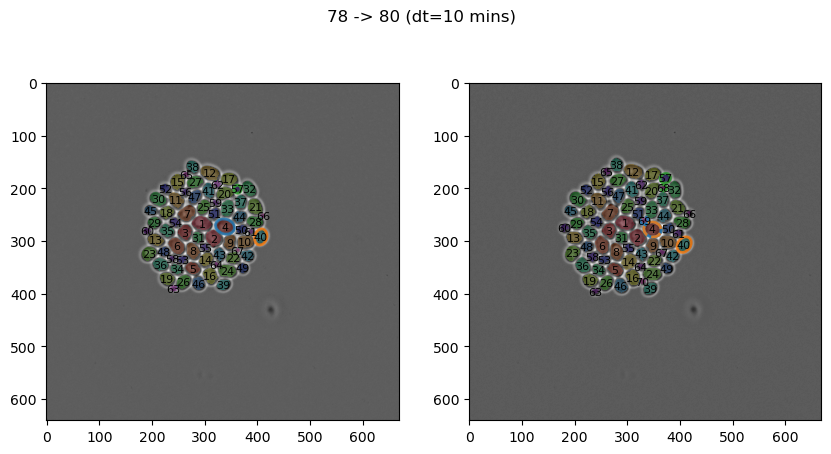

Expected 39->39, got 39->84


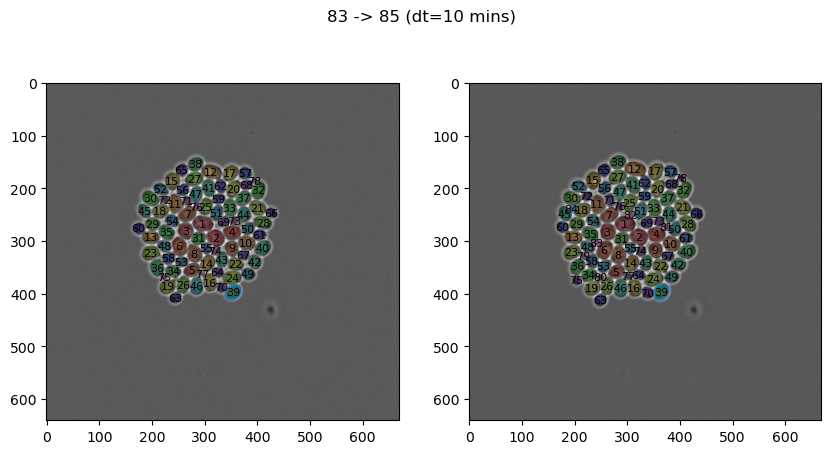

Expected 52->52, got 52->120


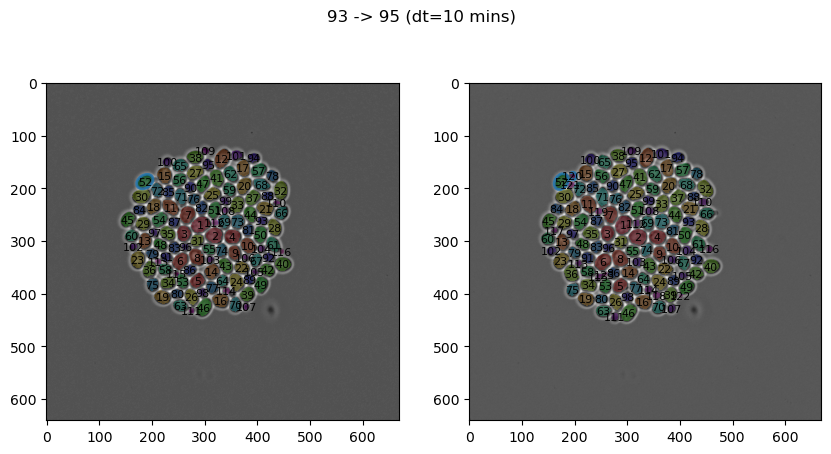

Expected 34->34, got 34->121
Expected 75->75, got 75->34
Expected 115->115, got 115->123


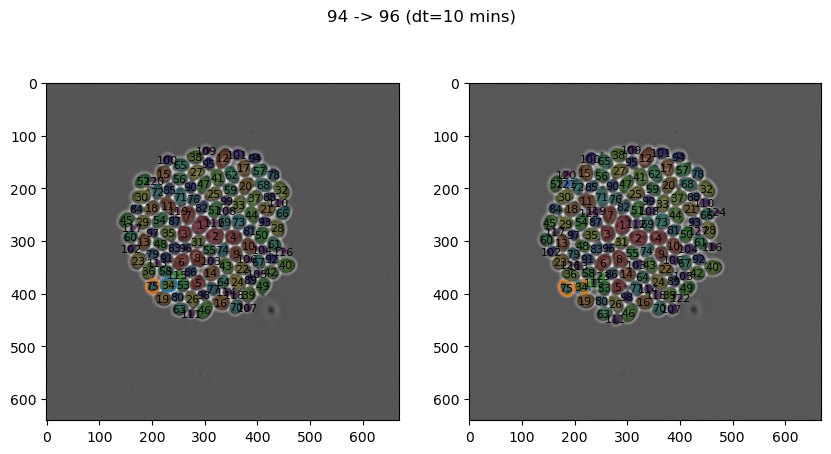

Expected 19->19, got 19->128
Expected 34->34, got 34->115
Expected 52->52, got 52->121
Expected 115->115, got 115->123
Expected 120->120, got 120->131
Expected 121->121, got 121->120
Expected 123->123, got 123->125


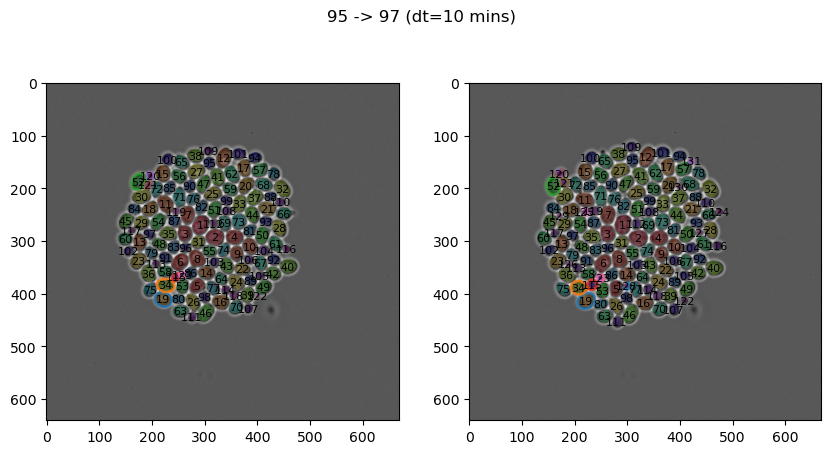

Expected 120->120, got 120->131


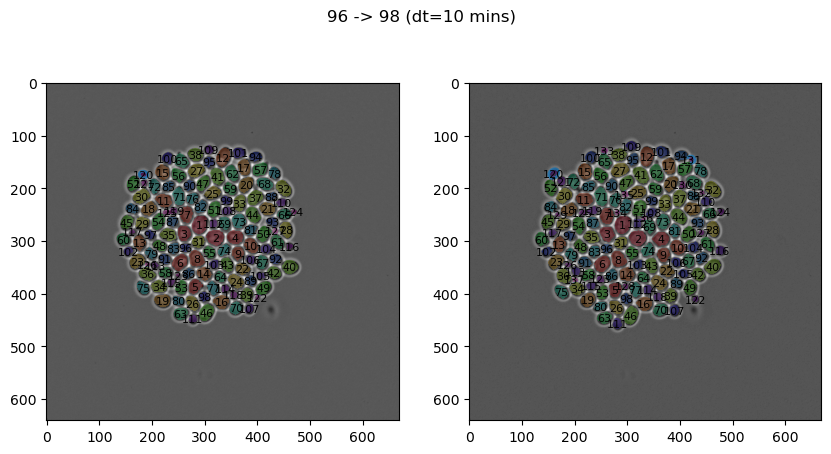

Expected 116->116, got 116->139


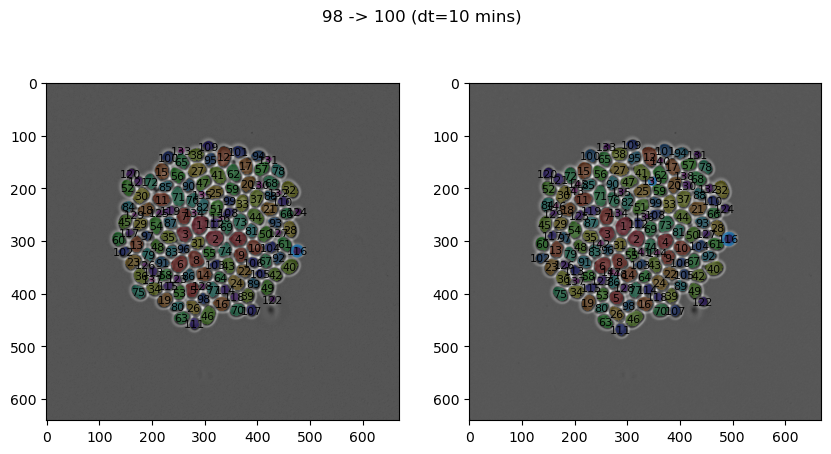

Expected 124->124, got 124->156


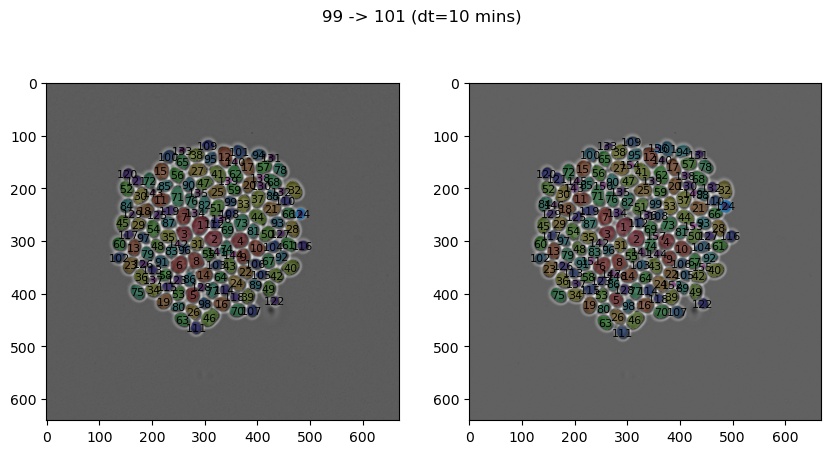

Expected 72->72, got 72->160
Expected 88->88, got 88->165
Expected 92->92, got 92->164
Expected 127->127, got 127->132
Expected 132->132, got 132->88
Expected 155->155, got 155->161


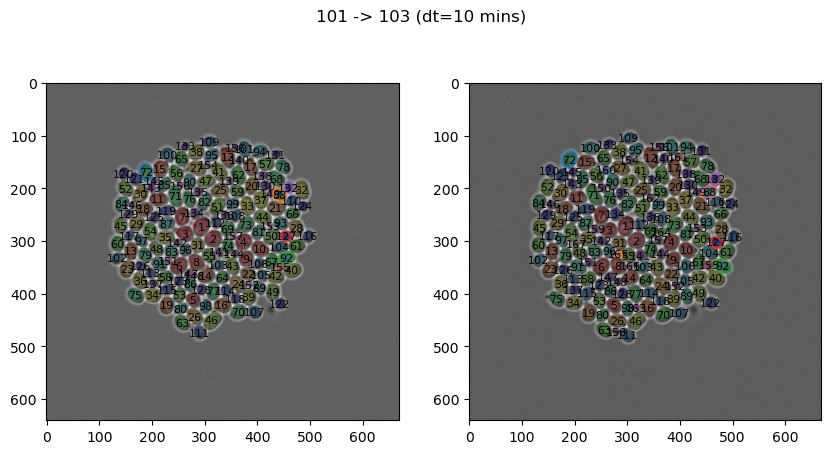

Expected 72->72, got 72->175
Expected 137->137, got 137->169
Expected 155->155, got 155->176


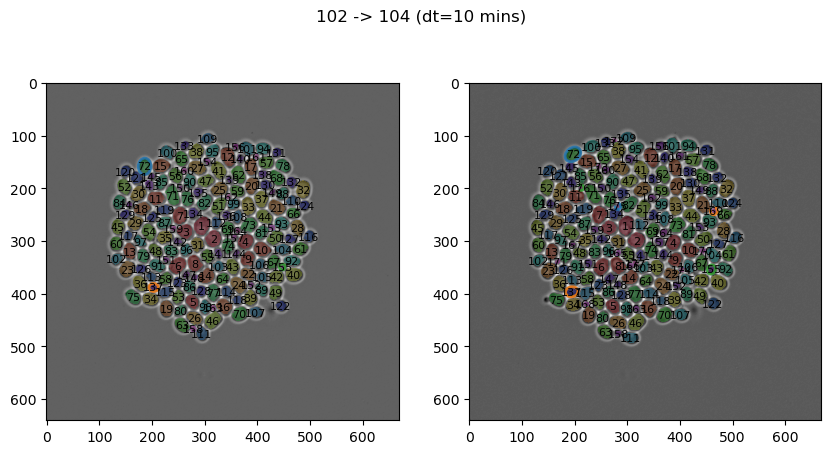

Expected 72->72, got 72->145
Expected 145->145, got 145->184


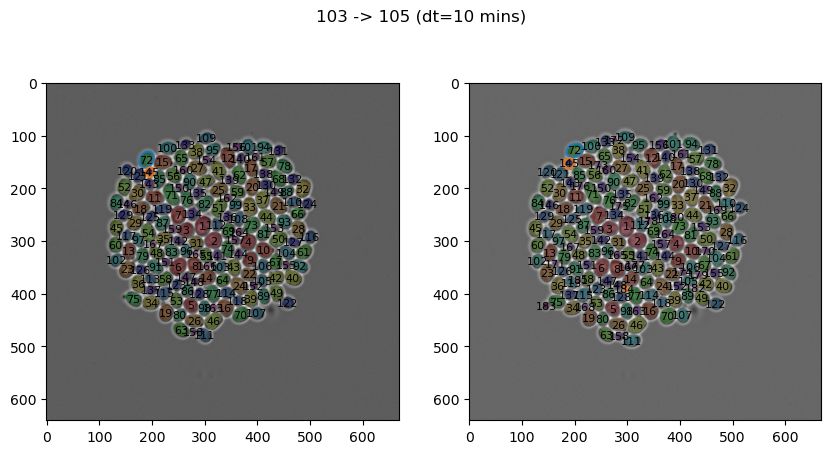

Expected 88->88, got 88->189
Expected 110->110, got 110->188
Expected 123->123, got 123->185
Expected 124->124, got 124->110


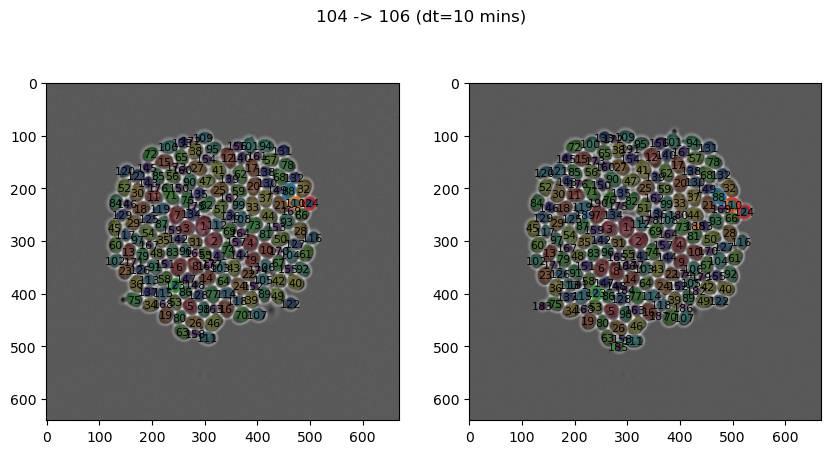

Expected 167->167, got 167->196
Expected 173->173, got 173->199
Expected 181->181, got 181->198


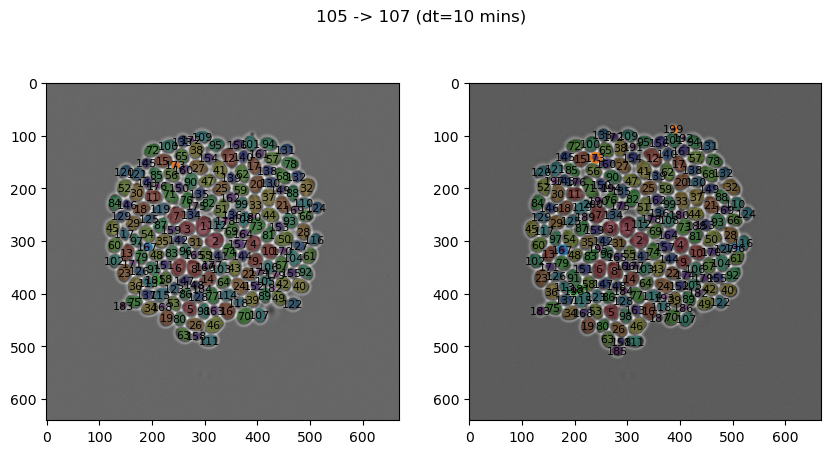

Expected 107->107, got 107->212
Expected 145->145, got 145->211


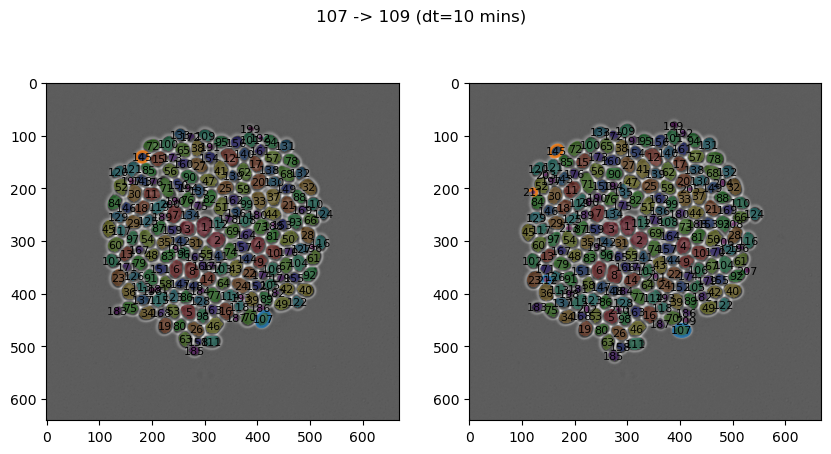

Expected 63->63, got 63->214
Expected 107->107, got 107->209
Expected 185->185, got 185->107
Expected 196->196, got 196->207


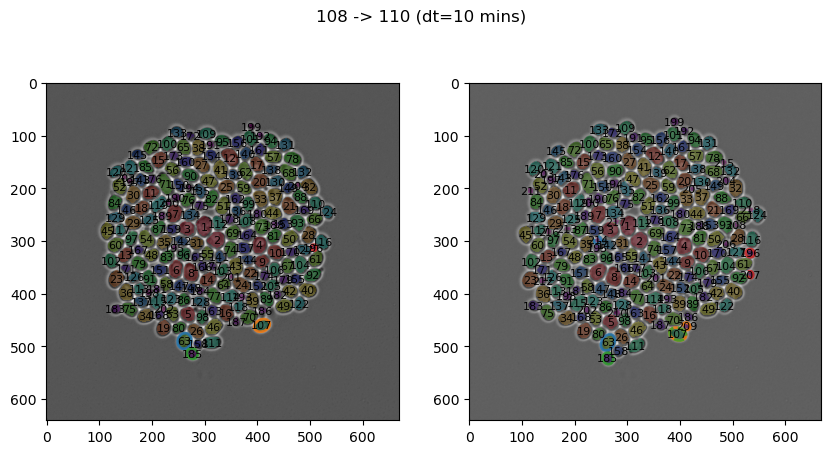

Expected 5->5, got 5->224
Expected 80->80, got 80->5
Expected 107->107, got 107->209
Expected 185->185, got 185->107
Expected 196->196, got 196->216
Expected 206->206, got 206->228
Expected 209->209, got 209->215


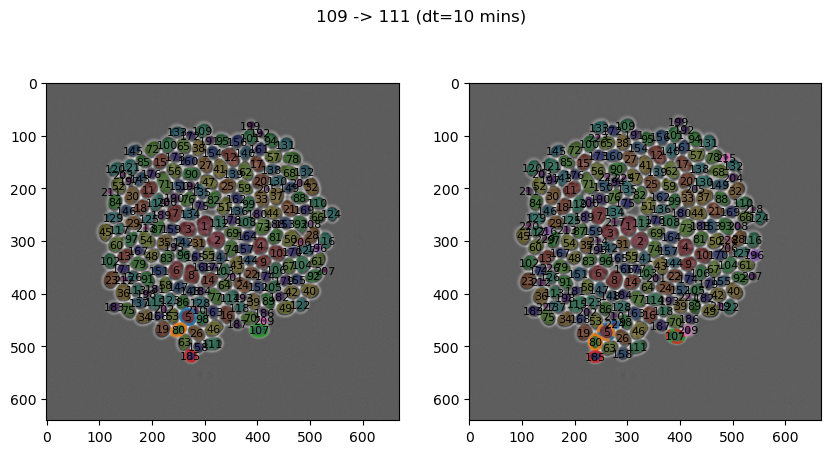

Expected 19->19, got 19->80
Expected 80->80, got 80->216
Expected 124->124, got 124->196
Expected 127->127, got 127->230
Expected 175->175, got 175->185
Expected 185->185, got 185->127
Expected 196->196, got 196->234
Expected 204->204, got 204->223
Expected 210->210, got 210->220
Expected 216->216, got 216->235


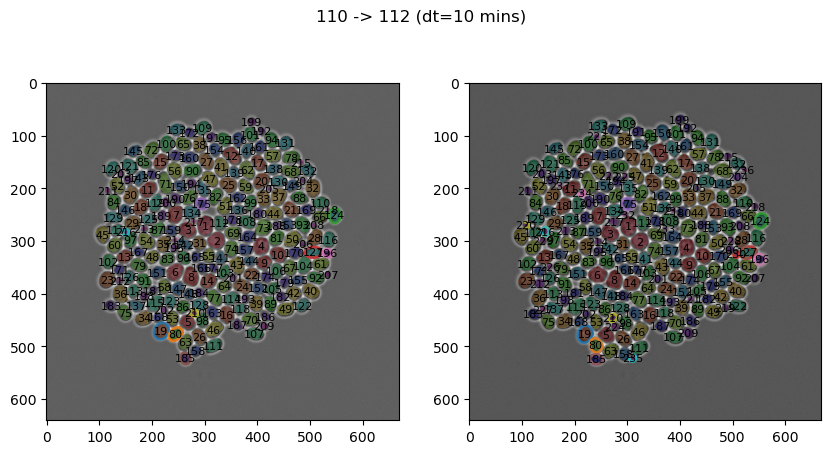

Expected 29->29, got 29->235
Expected 108->108, got 108->246
Expected 124->124, got 124->196
Expected 168->168, got 168->202
Expected 196->196, got 196->244
Expected 202->202, got 202->239


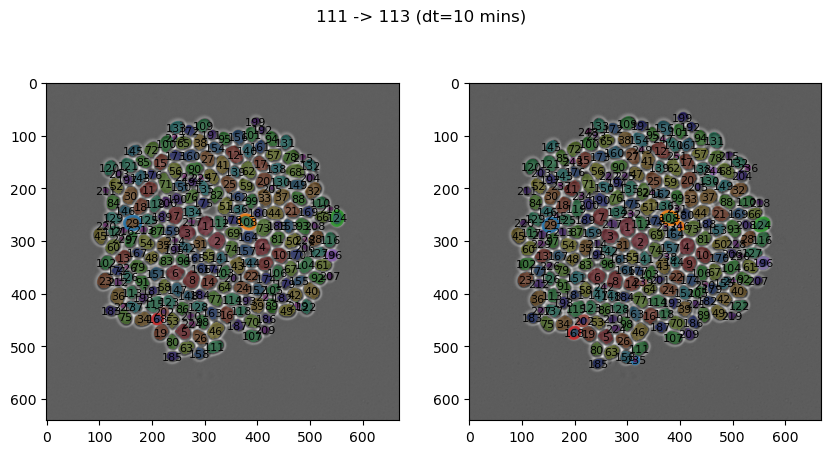

Expected 21->21, got 21->256
Expected 39->39, got 39->70
Expected 50->50, got 50->250
Expected 70->70, got 70->107
Expected 107->107, got 107->254
Expected 118->118, got 118->252
Expected 124->124, got 124->130
Expected 130->130, got 130->232
Expected 138->138, got 138->175
Expected 140->140, got 140->251


StopIteration: 

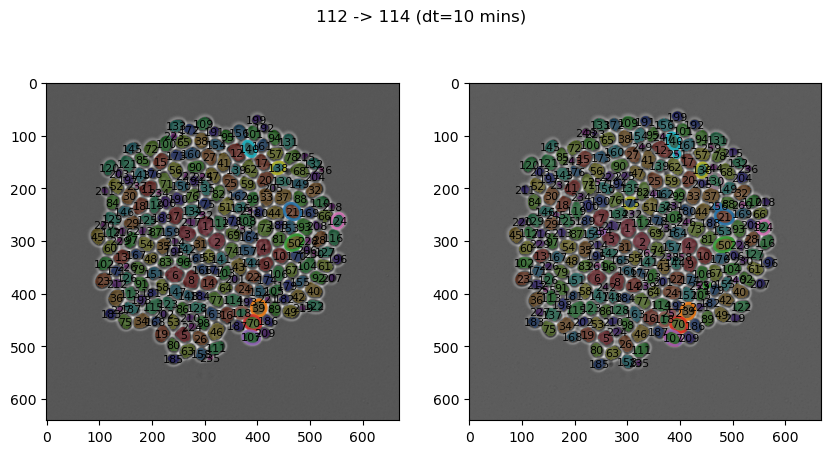

In [72]:
for _, row in res.query('(method == "gcn") and (fp > 0 or fn > 0) and (t2-t1 < 3)').sort_values('t1').iterrows():
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    vis.plot_visible(microscopy, row.t1, figax=(fig, axs[0]))
    vis.plot_segmentation(seg, row.t1, figax=(
        fig, axs[0]), cellids=True, alpha=0.2)
    vis.plot_visible(microscopy, row.t2, figax=(fig, axs[1]))
    vis.plot_segmentation(seg, row.t2, figax=(
        fig, axs[1]), cellids=True, alpha=0.2)
    fig.suptitle(f'{row.t1} -> {row.t2} (dt={row.timediff} mins)')
    ga = tracking.build_assgraph(tracking.build_cellgraph(
        feat, row.t1), tracking.build_cellgraph(feat, row.t2), include_target_feature=True)
    gat, *_ = tracking.to_data(ga)
    yhat = net.predict_assignment(gat)
    y = gat.y.cpu().numpy().reshape(yhat.shape)
    cellids1, cellids2 = seg.cell_ids(row.t1), seg.cell_ids(row.t2)
    coloriter = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for idx1, (idx2, idx2_hat) in enumerate(zip(np.argmax(y, axis=1), np.argmax(yhat, axis=1))):
        if idx2 != idx2_hat:
            color = next(coloriter)
            print(
                f'Expected {cellids1[idx1]}->{cellids2[idx2]}, got {cellids1[idx1]}->{cellids2[idx2_hat]}')
            vis._vis._plot_ellipse(feat._ellipse(cellids1[idx1], row.t1), figax=(
                fig, axs[0]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
            vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2], row.t2), figax=(
                fig, axs[1]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
            vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2_hat], row.t2), figax=(
                fig, axs[1]), color=color, linestyle='--', linewidth=2, alpha=0.8, draw_axes=False)
    plt.show()